In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [8]:
# LOAD IMAGES
imgs_left = glob.glob(r'C:\Users\K_kar\Downloads\Stereo_calibration_images\Stereo_calibration_images\left*.png')
imgs_right = glob.glob(r'C:\Users\K_kar\Downloads\Stereo_calibration_images\Stereo_calibration_images\right*.png')

assert imgs_right, imgs_left
assert (len(imgs_right) == len(imgs_left))
n_images = len(imgs_right)
imgs_right.sort()
imgs_left.sort()

# %% INITIALIZE CHECKERBOARD OBJECT POINTS
nb_vertical = 9
nb_horizontal = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # vector of vectors of calibration pattern points in the calibration pattern coordinate space
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = [] # 2d points in image plane.

# %% EXTRACT CHECKERBOARD CORNERS (AND DISPLAY THEM)
for i in range(n_images):
    img_left = cv2.imread(imgs_left[i])
    img_right = cv2.imread(imgs_right[i])
    gray_left = cv2.cvtColor(img_left,cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right,cv2.COLOR_BGR2GRAY)
    ret_left, corners_left = cv2.findChessboardCorners(gray_left, patternSize = (nb_vertical, nb_horizontal))
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, patternSize = (nb_vertical, nb_horizontal))
    # If found, add object points, image points (after refining them)
    if ret_left == True and ret_right == True:
        objpoints.append(objp)
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)
        # Draw and display the corners
        img_left = cv2.drawChessboardCorners(img_left, (nb_vertical,nb_horizontal), corners_left,ret_left)
        img_right = cv2.drawChessboardCorners(img_right, (nb_vertical,nb_horizontal), corners_right,ret_right)
        cv2.putText(img_left, "Left Camera", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(img_right, "Right Camera", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        img_l_r = np.vstack((img_l,img_r))
        windowname_1 = "Calibration Pattern (Left and Right Camera)"
        cv2.namedWindow(windowname_1, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(windowname_1, 600, 600)
        cv2.imshow(windowname_1,img_l_r)
        cv2.waitKey(5)
cv2.destroyAllWindows()

# %% STEREOCALIBRATE - COMPUTE (INTRINSIC) CAMERA MATRICES, DISTORTION COEFFICIENTS, ROTATION AND TRANSLATION BETWEEN THE TWO CAMERAS AND REPROJECTION ERROR
assert (img_l.shape[:2] == img_r.shape[:2])
h, w = img_l.shape[:2]

term_crit_sc = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
flags_sc = cv2.CALIB_RATIONAL_MODEL
ret_stereo,  mtx_left, dist_left, mtx_right, dist_right, mtx_R, mtx_T, mtx_E, mtx_F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, None, None, None, None, (w,h), flags=flags_sc, criteria=term_crit_sc)


# %% STEREORECTIFY - COMPUTE AND SAVE THE RECTIFICATION TRANSFORM AND PROJECTION MATRIX OF THE 2 CAMERAS, USING THE MATRICES COMPUTED BY STEREOCALIBRATE

mtx_R_left, mtx_R_right, mtx_P_left, mtx_P_right, mtx_Q, roi_rec_left, roi_rec_right = cv2.stereoRectify(mtx_left, dist_left, mtx_right, dist_right, (w,h), mtx_R, mtx_T, alpha=0)

# %% COMPUTE UNDISTORTION AND RECTIFICATION TRANSFORMATION MAP
map1x, map1y = cv2.initUndistortRectifyMap(mtx_left,dist_left,mtx_R_left,mtx_P_left,(w,h),cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(mtx_right,dist_right,mtx_R_right,mtx_P_right,(w,h),cv2.CV_32FC1)

In [9]:
# %% SAVE RECTIFIED CAMERA MATRICES AND UNDISTORTION/RECTIFICATION MAPS FOR FUTURE USE
dir_calib = (r"C:\Users\K_kar\Downloads\Stereo_calibration_images\matrix_calib_rectify")
np.save(dir_calib + "\projection_matrix_left", mtx_P_l)
np.save(dir_calib + "\projection_matrix_right", mtx_P_r)
np.save(dir_calib + "\map_left_x", map1x)
np.save(dir_calib + "\map_left_y", map1y)
np.save(dir_calib + "\map_right_x", map2x)
np.save(dir_calib + "\map_right_y", map2y)

# %% CHECK RESULT CORRECTNESS

img_l = cv2.imread(imgs_left[0])
cv2.imshow('Distorted Image', img_l)
cv2.waitKey()

img_l_undist_rect = cv2.remap(img_l, map1x, map1y, cv2.INTER_LINEAR)
cv2.imshow('Undistorted and Rectified Image', img_l_undist_rect)
cv2.waitKey()
cv2.destroyAllWindows()

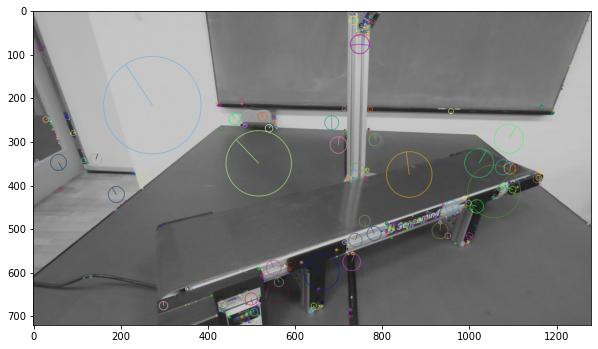

In [10]:
#map the matrix file with images
img1 = cv2.imread(r'C:\Users\K_kar\OneDrive\Pictures\31392 Perception for Autonomous Systems\Final Project\Stereo_conveyor_without_occlusions\left\1585434279_805531979_Left.png', 0)
img2 = cv2.imread(r'C:\Users\K_kar\OneDrive\Pictures\31392 Perception for Autonomous Systems\Final Project\Stereo_conveyor_without_occlusions\right\1585434279_805531979_right.png', 0)
rect_map_left_x = np.load(r'C:\Users\K_kar\Downloads\Stereo_calibration_images\matrix_calib_rectify\map_left_x.npy')
rect_map_left_y = np.load(r'C:\Users\K_kar\Downloads\Stereo_calibration_images\matrix_calib_rectify\map_left_y.npy')
rect_map_right_x = np.load(r'C:\Users\K_kar\Downloads\Stereo_calibration_images\matrix_calib_rectify\map_right_x.npy')
rect_map_right_y = np.load(r'C:\Users\K_kar\Downloads\Stereo_calibration_images\matrix_calib_rectify\map_right_y.npy')
img1 = cv2.remap(img1, rect_map_left_x, rect_map_left_y, cv2.INTER_LINEAR)
img2 = cv2.remap(img2, rect_map_right_x, rect_map_right_y, cv2.INTER_LINEAR)
"""
Detect keypoints here
"""
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

In [11]:
"""
Implement Flann Based matcher here
matches = ...
"""

# FLANN parameters
flann = cv2.FlannBasedMatcher()
matches = flann.knnMatch(des1,des2,k=2)
matches = [m for m, n in matches]

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

In [12]:
nb_matches = 200

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    

#Implement findFundamentalMat here:
F, mask = cv2.findFundamentalMat(pts1, pts2)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [13]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

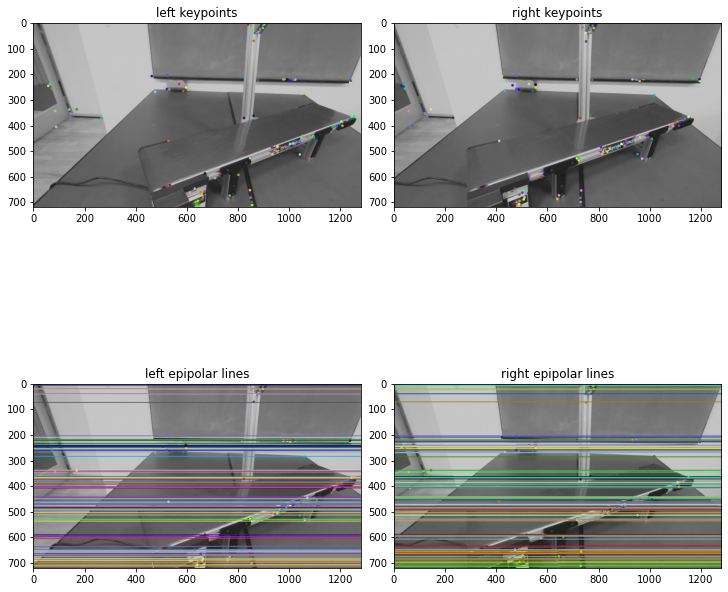

In [14]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()